In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [3]:
plt.rcParams.update({'font.size': 14})

# Load data
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sub_sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

print (train.shape, test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


# Understanding Data

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.duplicated().sum()

0

In [6]:
train = train.drop_duplicates().reset_index(drop=True)

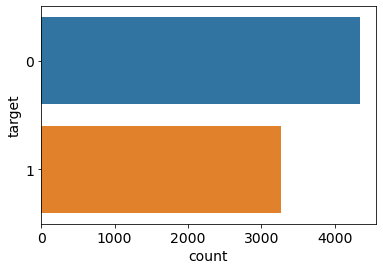

In [7]:
# Class balance
# train.target.value_counts()
sns.countplot(y=train.target);

In [8]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

#### Check number of unique keywords, and whether they are the same for train and test sets

In [10]:
print (train.keyword.nunique(), test.keyword.nunique())

221 221


#### Most common words

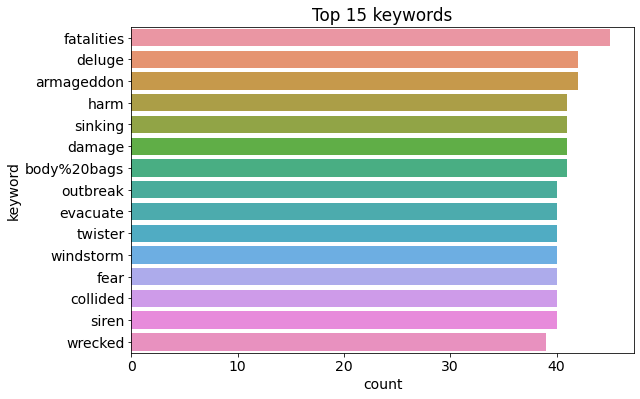

In [11]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

#### Top 10 words in disaster and non-disaster tweets

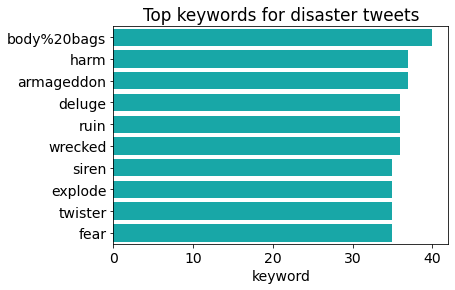

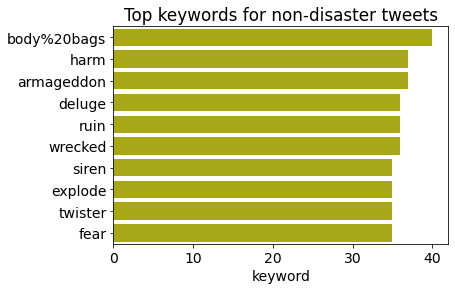

In [12]:
kw_nd = train[train.target==0].keyword.value_counts().head(10)


sns.barplot(kw_nd, kw_nd.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.show()
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

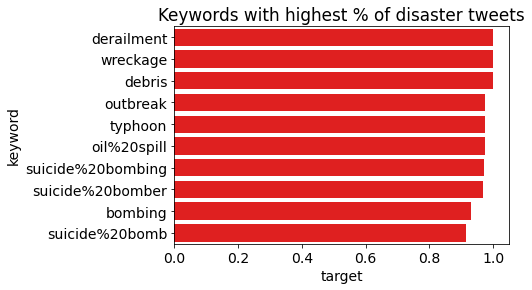

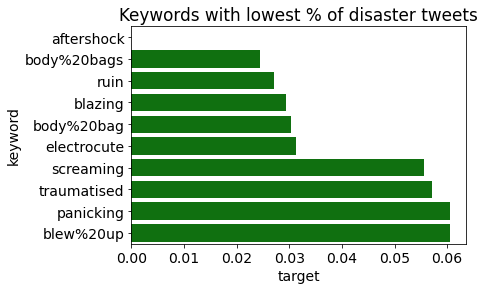

In [13]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

sns.barplot(top_d, top_d.index, color='red')
plt.title('Keywords with highest % of disaster tweets')
plt.show()
sns.barplot(top_nd, top_nd.index, color='green')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

In [14]:
# Check number of unique keywords and locations
print (train.location.nunique(), test.location.nunique())

3341 1602


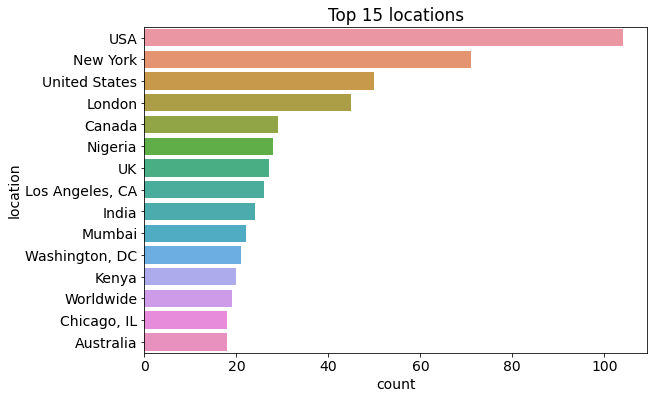

In [15]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.

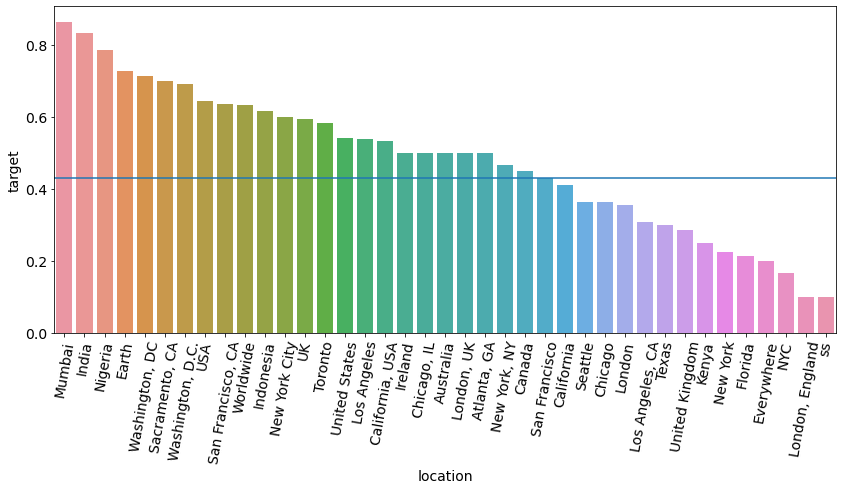

In [16]:
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()


# Cleaning the data

In [17]:
import re
test_str = train.loc[417, 'text']
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text)           # Remove line breaks
    text = re.sub('\s+', ' ', text).strip()  # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [18]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

In [19]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 18) (3263, 17)


In [20]:
train.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

From above, we came to know all the statistics have very low co-relation

In [21]:
from nltk import FreqDist, word_tokenize

In [22]:
# Make a set of stop words
stopwords = set(STOPWORDS)

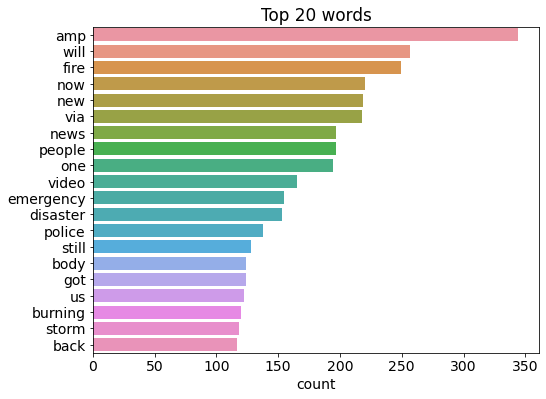

In [23]:
# Unigrams
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

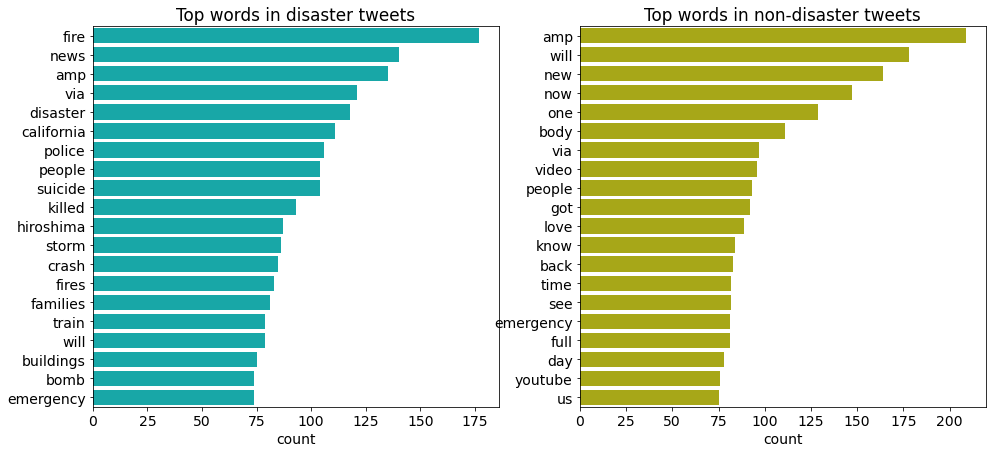

In [24]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='c')
plt.title('Top words in disaster tweets')
plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

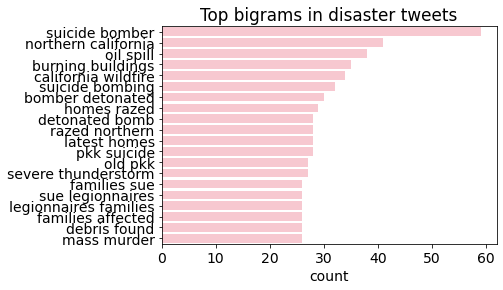

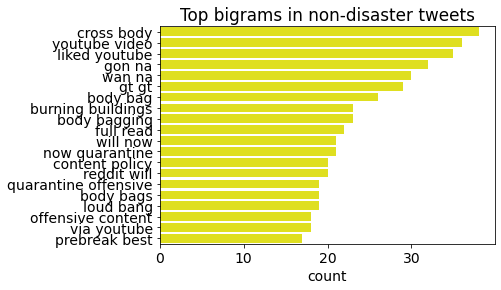

In [25]:
# Bigrams

from nltk import bigrams

bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='pink')
plt.title('Top bigrams in disaster tweets')
plt.show()
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

# Encoding and Vectorizers

As part of feature generation, we will:

- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns


In [26]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


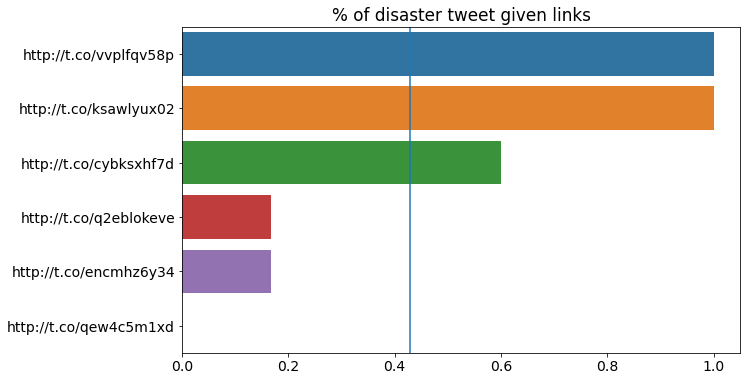

In [28]:
_ = (X_train_link.transpose().dot(train['target']) / X_train_link.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=_, y=_.index)
plt.axvline(np.mean(train.target))
plt.title('% of disaster tweet given links')
plt.show()

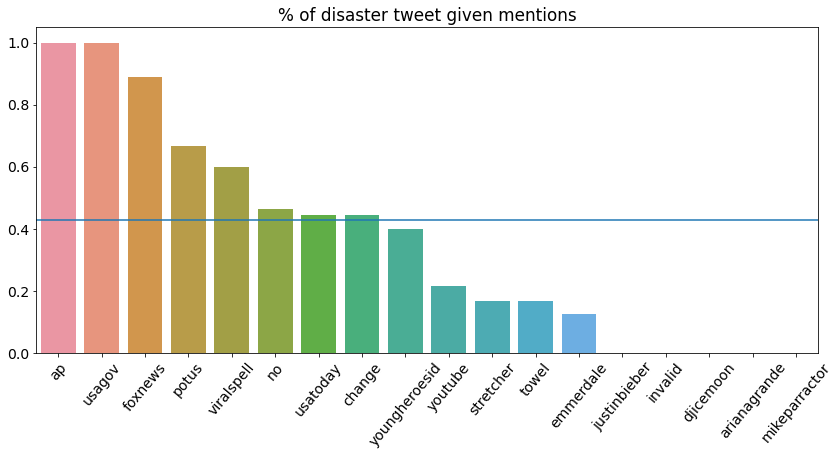

In [29]:
_ = (X_train_men.transpose().dot(train['target']) / X_train_men.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=_.index, y=_)
plt.axhline(np.mean(train.target))
plt.title('% of disaster tweet given mentions')
plt.xticks(rotation = 50)
plt.show()

In [30]:
hash_rank = (X_train_hash.transpose().dot(train['target']) / X_train_hash.sum(axis=0)).sort_values(ascending=False)
print('Hashtags with which 100% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==1].index))
print('Total: ' + str(len(hash_rank[hash_rank==1])))
print('Hashtags with which 0% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==0].index))
print('Total: ' + str(len(hash_rank[hash_rank==0])))

Hashtags with which 100% of Tweets are disasters: 
['yyc', 'japan', 'science', 'rohingya', 'okwx', 'newyork', 'myanmar', 'mumbai', 'wx', 'libya', 'india', 'socialnews', 'hiroshima', 'hailstorm', 'earthquake', 'disaster', 'breaking', 'bestnaijamade', 'antioch', 'africa', 'sittwe', 'mh370', 'abstorm', 'worldnews', 'wildfire', 'wildfires']
Total: 26
Hashtags with which 0% of Tweets are disasters: 
['np', 'summerfate', 'job', 'jobs', 'animalrescue', 'kindle', 'fashion', 'bb17', 'dnb', 'ices', 'beyhive', 'edm', 'technology', 'dubstep', 'trapmusic', 'military', 'dance', 'soundcloud']
Total: 18


In [31]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1691)


In [32]:
# Joining the dataframes together

train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1842) (3263, 1841)


## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target

lr = LogisticRegression(solver='liblinear', random_state=777) # Other solvers have failure to converge problem

pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

In [34]:
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.8585


In [35]:
# F-1 score
from sklearn.metrics import f1_score

print ('Training f-1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))

Training f-1 score: 0.8255


In [36]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,3988,354
1,723,2548
